## Analysis of flat10MIP output

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

# Load Data (from file)

The data is slow to load, so make an intermediate processed data matrix that contains latitude range means for different variables

created in create_metrics_matrix.ipynb

and saved as a netcdf file

load it here

In [4]:
ds_C_global = xr.open_dataset("C_metrics_matrix.nc")

In [5]:
latlist=['global','highlat','troplat','midlat']
varlist=varlist_analyze


In [6]:
ds_C_global

<xarray.Dataset>
Dimensions:   (time: 350, model: 8, run: 3, var: 7, latrange: 4)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
  * model     (model) object 'ACCESS-ESM1-5' 'CESM2' ... 'HadCM3LC-Bris'
  * run       (run) object 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) object 'cVeg' 'cSoil' 'cTot' 'cLitter' 'nbp' 'gpp' 'rh'
  * latrange  (latrange) object 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 ...

# Plots

In [7]:
# switch to the list of variables to analyze

varlist=varlist_analyze

print(varlist)

['cVeg', 'cSoil', 'cTot', 'cLitter', 'nbp', 'gpp', 'rh']


<xarray.Dataset>
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
    model     <U13 'ACCESS-ESM1-5'
    run       <U6 'flat10'
    var       <U4 'cTot'
    latrange  <U6 'global'
Data variables:
    data      (time) float64 ...


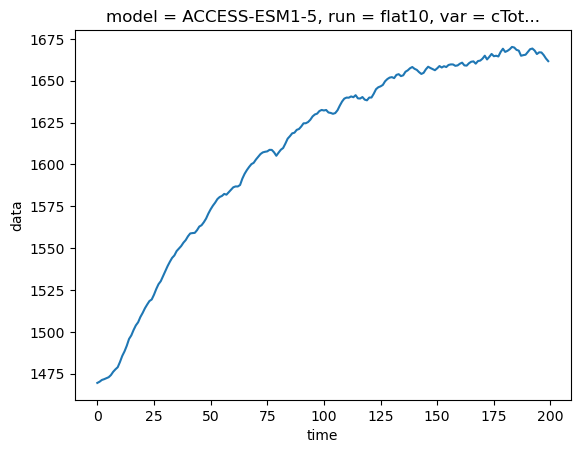

In [8]:
# to load data from this ds

# Access data for one model, run, var
#subset = ds.sel(time=0.1, model='model1', run='run1', var='var1')

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var='cTot', latrange='global')

print(subset)

subset.data[0:200].plot()

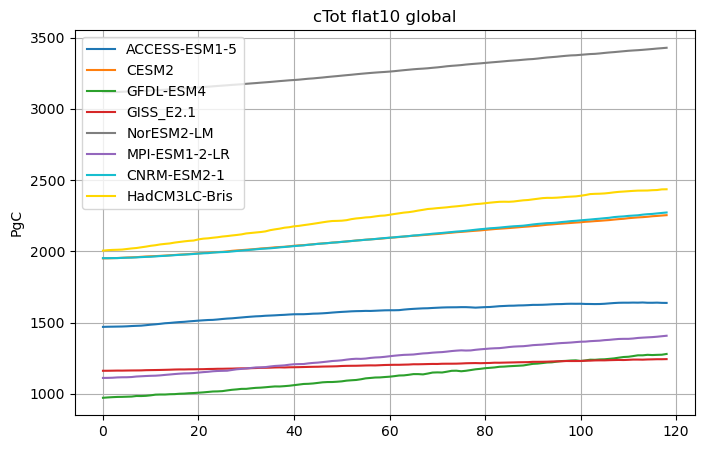

In [9]:
fig = plt.figure(figsize=(8,5))

e=0
v=2
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:120].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('PgC')
plt.legend()
plt.grid()

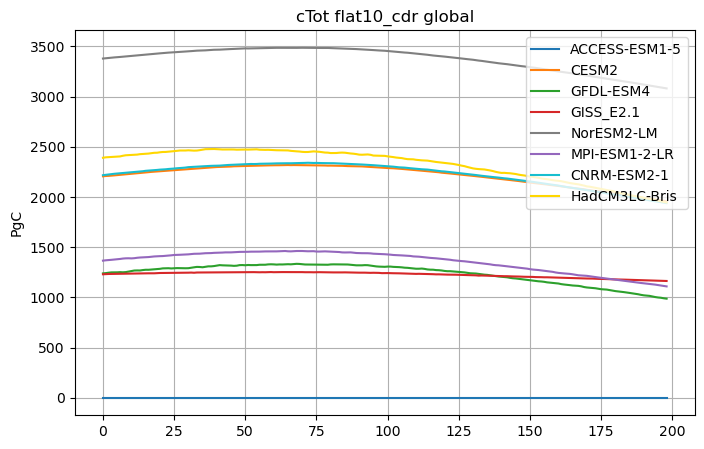

In [10]:
fig = plt.figure(figsize=(8,5))

e=2
v=2
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:200].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('PgC')
plt.legend()
plt.grid()

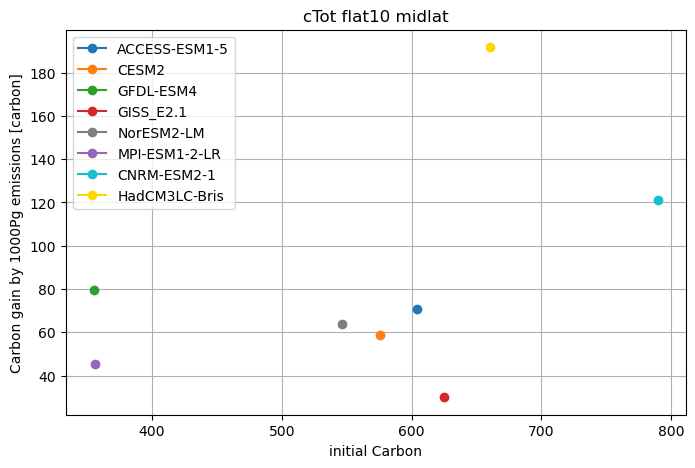

In [11]:
fig = plt.figure(figsize=(8,5))


e=0
v=2
l=3
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

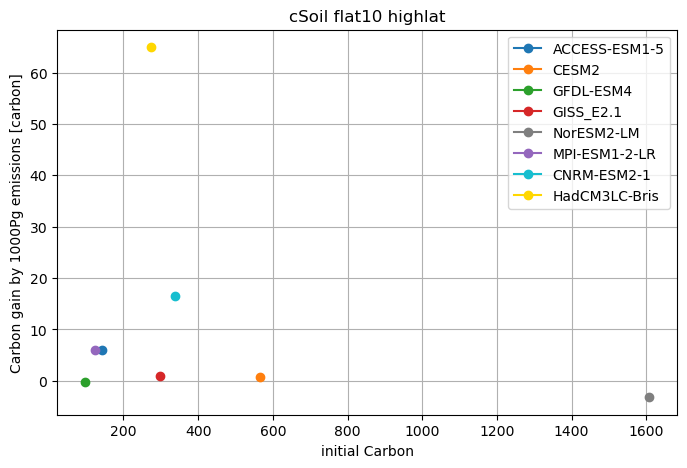

In [12]:
fig = plt.figure(figsize=(8,5))


e=0
v=1
l=1
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

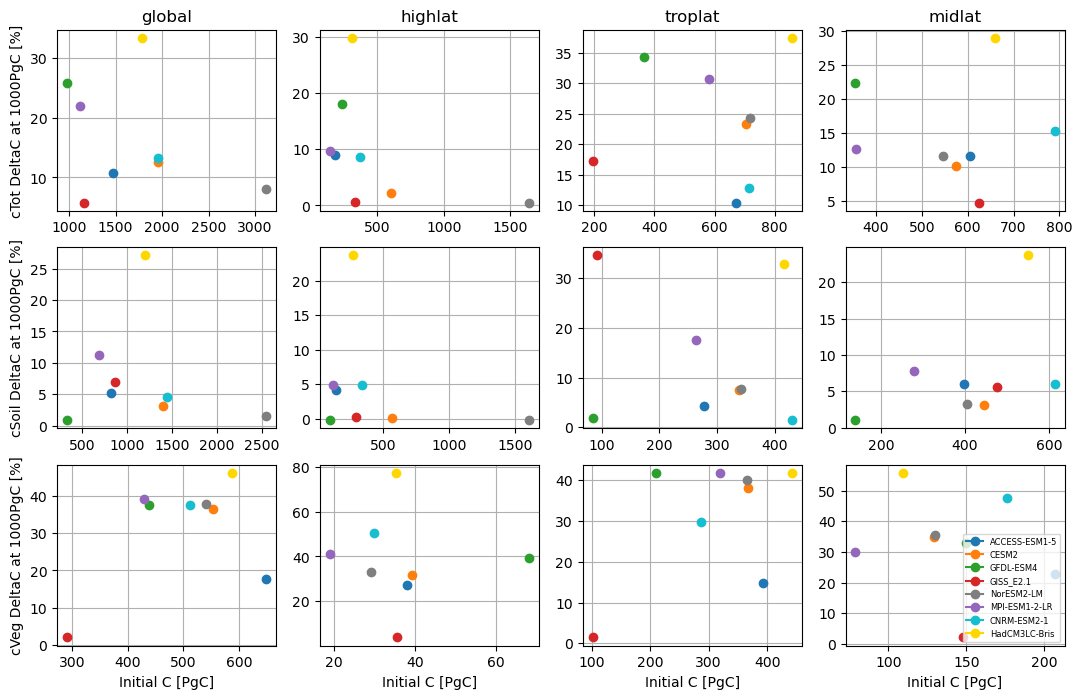

In [29]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [%]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [%]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [%]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()
        
axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_pct.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_pct.jpg", bbox_inches='tight')


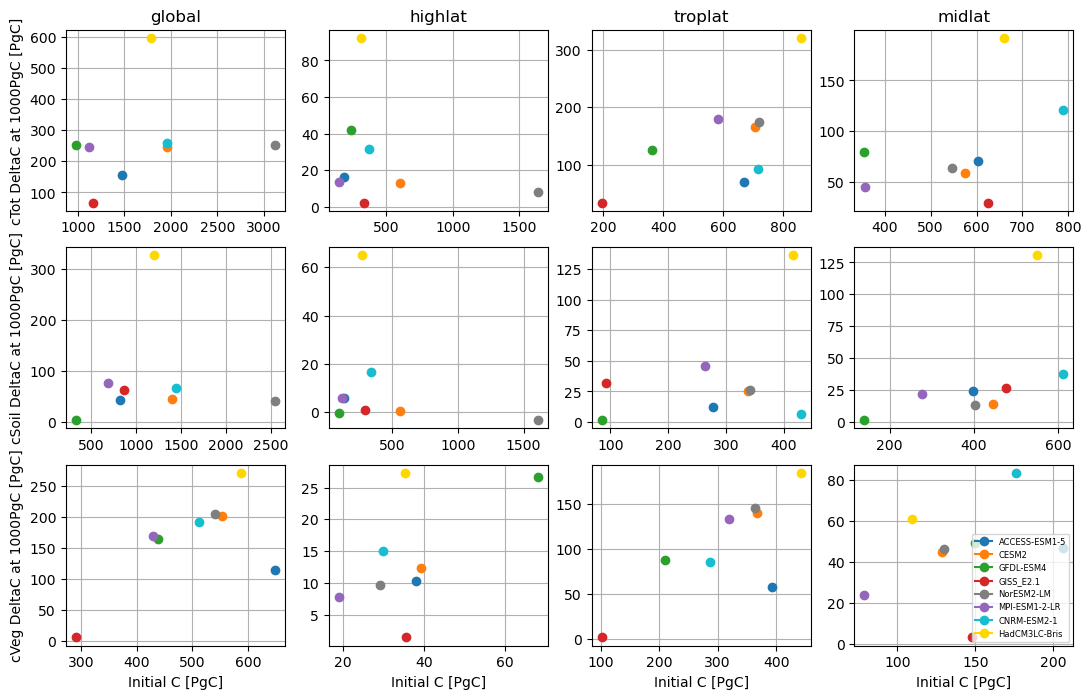

In [30]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC.jpg", bbox_inches='tight')


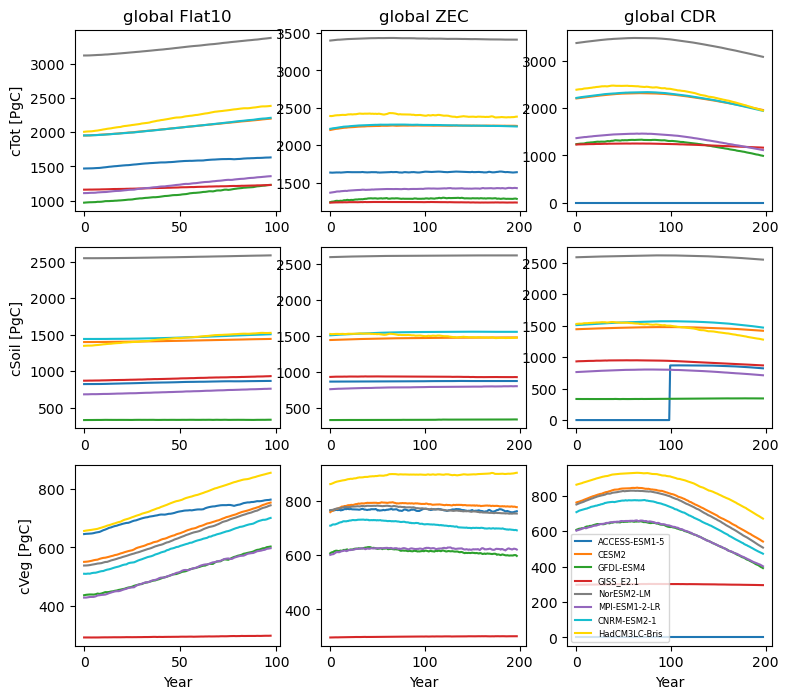

In [32]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:99]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title(latlist[l] +' Flat10')
axes[0,1].set_title(latlist[l] +' ZEC')
axes[0,2].set_title(latlist[l] +' CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')


axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


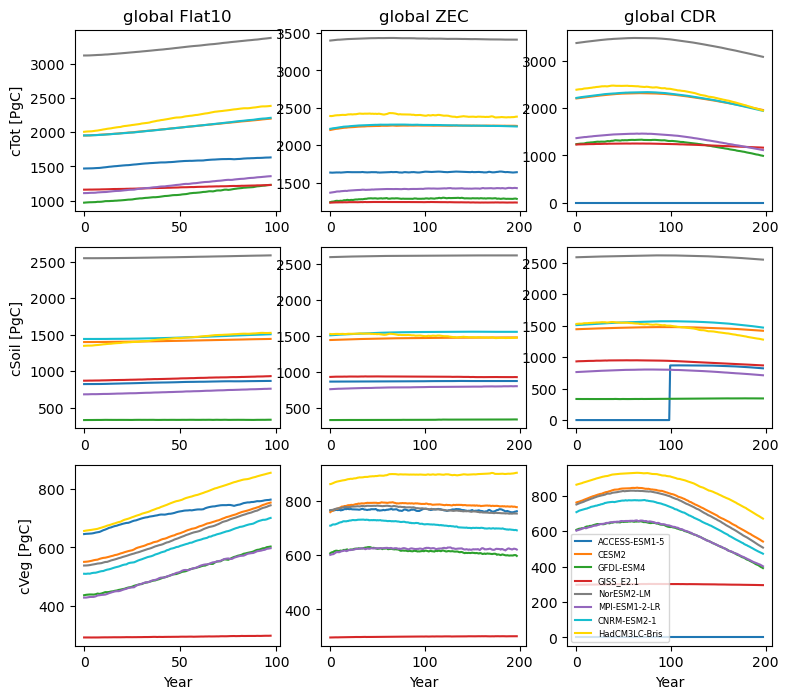

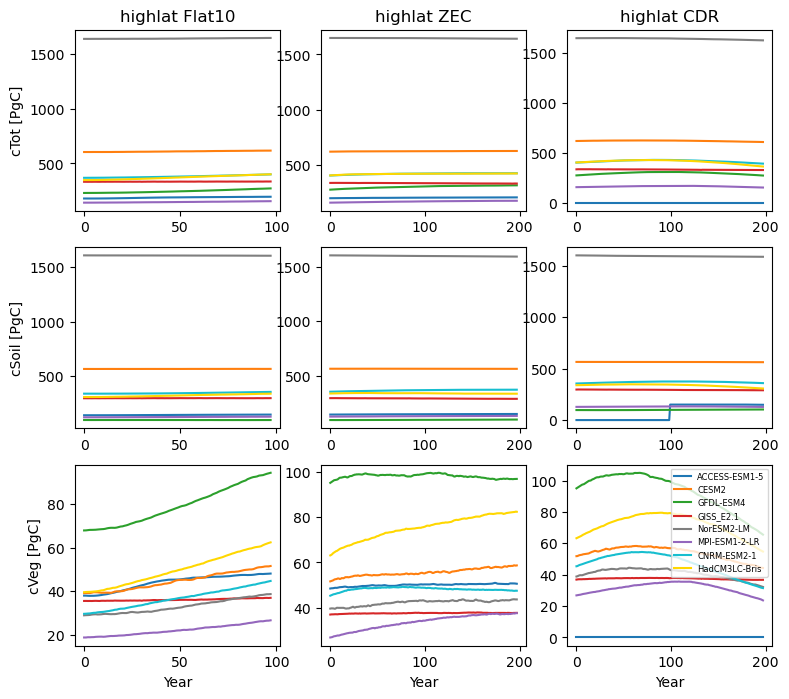

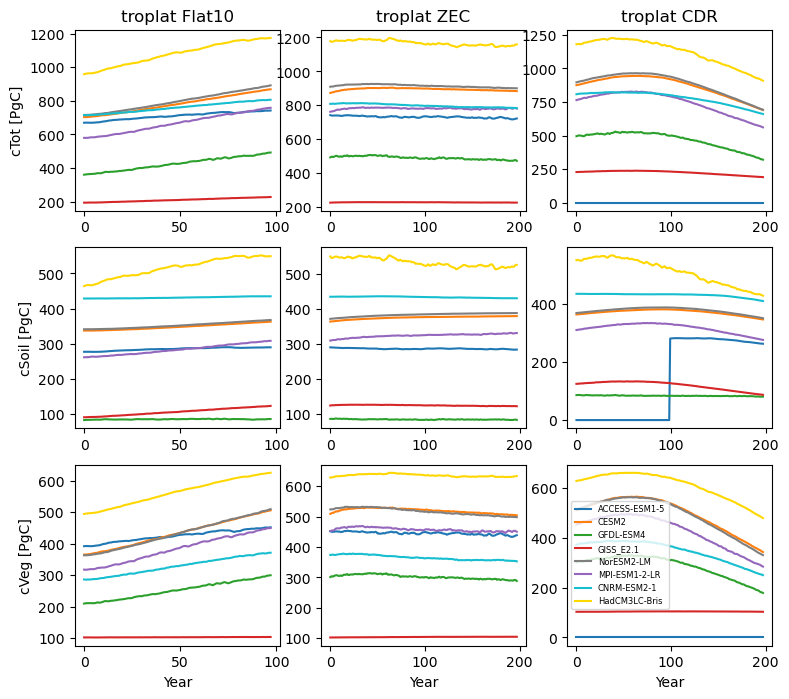

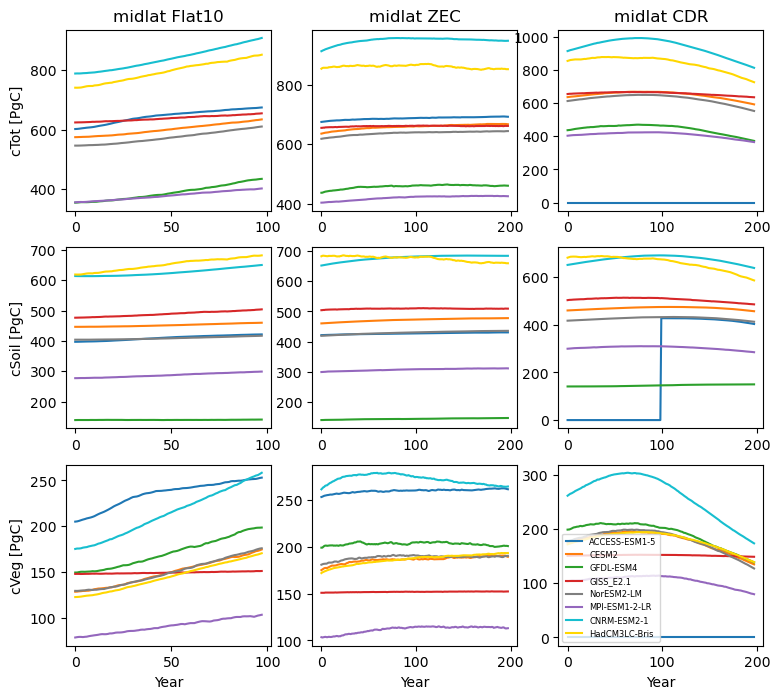

In [16]:
# loop over all latitude bands
for l in range(len(latlist)):

    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    #axes=axes.flatten()
    
    # rows are carbon variables, cTot, cVeg, cSoil
    # columns are total change, % change
    vlist = [2,1,0]
    
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for vi in range(len(vlist)):
            v=vlist[vi]
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:99]
            axes[vi,0].plot(Cts,label=model,color=mcolor)
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,1].plot(Cts,label=model,color=mcolor)
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,2].plot(Cts,label=model,color=mcolor)
    
    
    
    axes[0,0].set_title(latlist[l] +' Flat10')
    axes[0,1].set_title(latlist[l] +' ZEC')
    axes[0,2].set_title(latlist[l] +' CDR')
    
    
    axes[2,0].set_xlabel('Year')
    axes[2,1].set_xlabel('Year')
    axes[2,2].set_xlabel('Year')
    
    axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
    axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
    axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')
    
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


### vegetation vs. soil sinks

vegetation and soil sinks are calculated from vegetation carbon and soil carbon

we want to know the initital stocks as well as the change over time under different experiemnts



### reversibility

reversibility is the state of the system after cumulative emissions reach zero in the flat10-cdr experiment

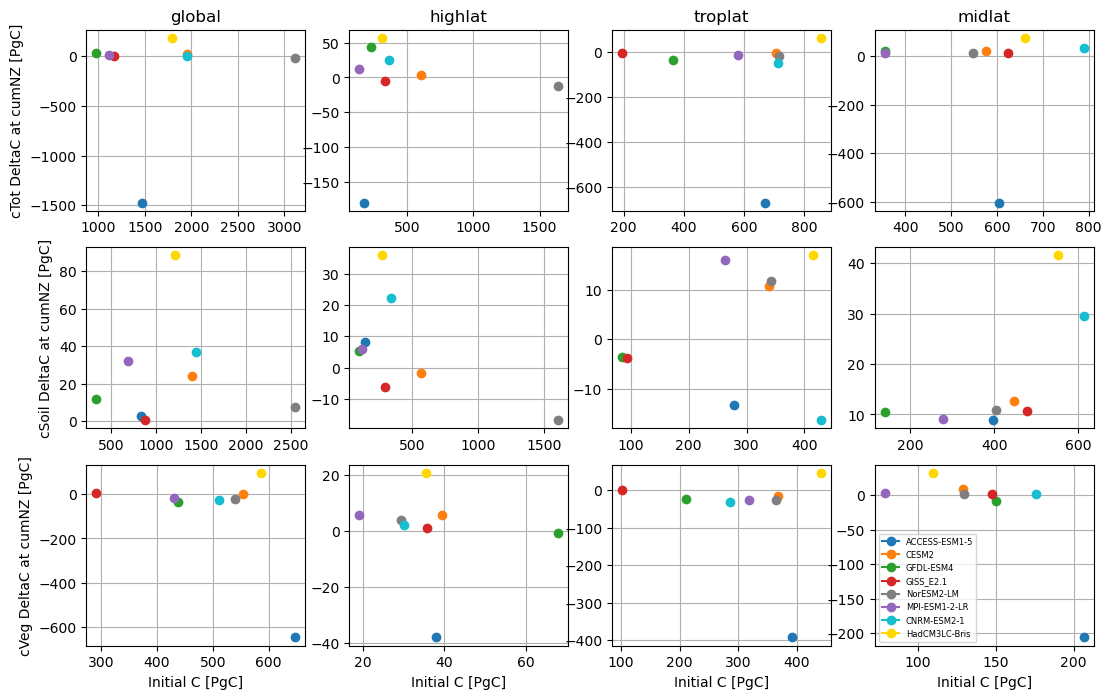

In [27]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            
            #axes[vi,l].grid() # this doesn't seem to work
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


### timing of peak land sink

timing of peak land sink comes from the maximum in globally averaged cumulative land carbon sink in flat10-cdr experiment

### TCRE and ZEC 

TCRE is calcualted as the warming that occurs at year 100 in the flat10 experiment

ZEC is the change in warming after net-zero emissions, which is the temperature at a given time in the flat10-zec experiment minus the tempeature at year 100 in the flat10 experiment


These numbers are copied from Ben Sanderson's flat10 repository notebook. Not the best way to do this.

In [18]:

esm_tcre_flat10= [1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122, 1.50077057, 1.72289277, 2.503865,   1.86102962, 2.02051318]
esm_zec50_flat10= [ 0.20830381, -0.2631313, -0.20984793, -0.18912964, -0.22547232, -0.13938904,  0.00142626,  0.272745,    0.059901,    0.0960024 ]
esm_zec90_flat10= [ 0.14918208, -0.13839814, -0.12847126, -0.14947052, -0.21317124, -0.16652226, 0.07068745,  0.18805,     0.10838604,  0.11575942]
esm_zec100_flat10= [0.13327324, -0.12651117, -0.1135391,  -0.24052734, -0.31327247, -0.2394135,  0.10518711, 0.20698,     0.1190201,   0.15074751]
esm_tpw_flat10= [  7., -10., -29., -4., -33.,   1., -10.,  -1.,   3.,  11.]
esm_tnz_flat10= [ 0.08160996,  0.05382003, -0.09170842,  0.12097321, -0.02551466, -0.06321108,  0.10861629,  0.162655,    0.07346749, -0.03127059]
esm_tr1000_flat10= [ 0.23198843,  0.029688,   -0.25358582,  0.01142578, -0.22908808, -0.23681939, 0.02917725,  0.48317,    0.19768906,  0.16988671]
esm_tr0_flat10= [ 0.17284241,  0.41951067, -0.1129776,  -0.56428833, -0.30888033, -0.29384002,  0.37563933,         np.nan,  0.25246087,  0.14777742]


print("TCRE:", esm_tcre_flat10)
print("ZEC50:", esm_zec50_flat10)
print("ZEC90:", esm_zec90_flat10)
print("ZEC100:", esm_zec100_flat10)
print("TPW:", esm_tpw_flat10)
print("TNZ:", esm_tnz_flat10)
print("TR1000:", esm_tr1000_flat10)
print("TR0:", esm_tr0_flat10)

esm_metrics_flat10 = pd.DataFrame({})
esm_metrics_flat10['tcre']=esm_tcre_flat10
esm_metrics_flat10['zec50']=esm_zec50_flat10
esm_metrics_flat10['zec90']=esm_zec100_flat10
esm_metrics_flat10['zec100']=esm_zec100_flat10
esm_metrics_flat10['tpw']=esm_tpw_flat10
esm_metrics_flat10['tnz']=esm_tnz_flat10
esm_metrics_flat10['tr1000']=esm_tr1000_flat10
esm_metrics_flat10['tr0']=esm_tr0_flat10

mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM','UVic-ESCM-2-10','HadCM3LC-Bris']

esm_metrics_flat10.index=mdls


esm_metrics_flat10

TCRE: [1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122, 1.50077057, 1.72289277, 2.503865, 1.86102962, 2.02051318]
ZEC50: [0.20830381, -0.2631313, -0.20984793, -0.18912964, -0.22547232, -0.13938904, 0.00142626, 0.272745, 0.059901, 0.0960024]
ZEC90: [0.14918208, -0.13839814, -0.12847126, -0.14947052, -0.21317124, -0.16652226, 0.07068745, 0.18805, 0.10838604, 0.11575942]
ZEC100: [0.13327324, -0.12651117, -0.1135391, -0.24052734, -0.31327247, -0.2394135, 0.10518711, 0.20698, 0.1190201, 0.15074751]
TPW: [7.0, -10.0, -29.0, -4.0, -33.0, 1.0, -10.0, -1.0, 3.0, 11.0]
TNZ: [0.08160996, 0.05382003, -0.09170842, 0.12097321, -0.02551466, -0.06321108, 0.10861629, 0.162655, 0.07346749, -0.03127059]
TR1000: [0.23198843, 0.029688, -0.25358582, 0.01142578, -0.22908808, -0.23681939, 0.02917725, 0.48317, 0.19768906, 0.16988671]
TR0: [0.17284241, 0.41951067, -0.1129776, -0.56428833, -0.30888033, -0.29384002, 0.37563933, nan, 0.25246087, 0.14777742]


,tcre,zec50,zec90,zec100,tpw,tnz,tr1000,tr0
ACCESS-ESM1-5,1.753011,0.208304,0.133273,0.133273,7.0,0.081610,0.231988,0.172842
CESM2,1.951469,-0.263131,-0.126511,-0.126511,-10.0,0.053820,0.029688,0.419511
GFDL-ESM4,1.454654,-0.209848,-0.113539,-0.113539,-29.0,-0.091708,-0.253586,-0.112978
GISS_E2.1,1.621638,-0.189130,-0.240527,-0.240527,-4.0,0.120973,0.011426,-0.564288
NorESM2-LM,1.178211,-0.225472,-0.313272,-0.313272,-33.0,-0.025515,-0.229088,-0.308880
MPI-ESM1-2-LR,1.500771,-0.139389,-0.239414,-0.239414,1.0,-0.063211,-0.236819,-0.293840
CNRM-ESM2-1,1.722893,0.001426,0.105187,0.105187,-10.0,0.108616,0.029177,0.375639
UKESM,2.503865,0.272745,0.206980,0.206980,-1.0,0.162655,0.483170,NaN
UVic-ESCM-2-10,1.861030,0.059901,0.119020,0.119020,3.0,0.073467,0.197689,0.252461
HadCM3LC-Bris,2.020513,0.096002,0.150748,0.150748,11.0,-0.031271,0.169887,0.147777


In [19]:
## Our list of models is different from the full list, so make a subset of the data

il = [mdls.index(i) for i in modellist]
il

[0, 1, 2, 3, 4, 5, 6, 9]

In [20]:
esm_metrics_flat10_subset=esm_metrics_flat10['tcre'][il].values

esm_metrics_flat10_subset

array([1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122,
       1.50077057, 1.72289277, 2.02051318])

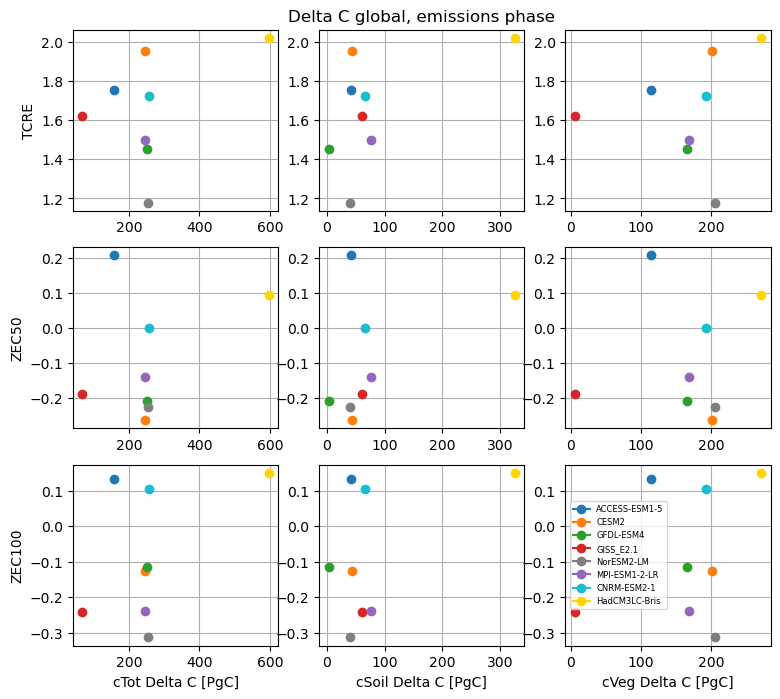

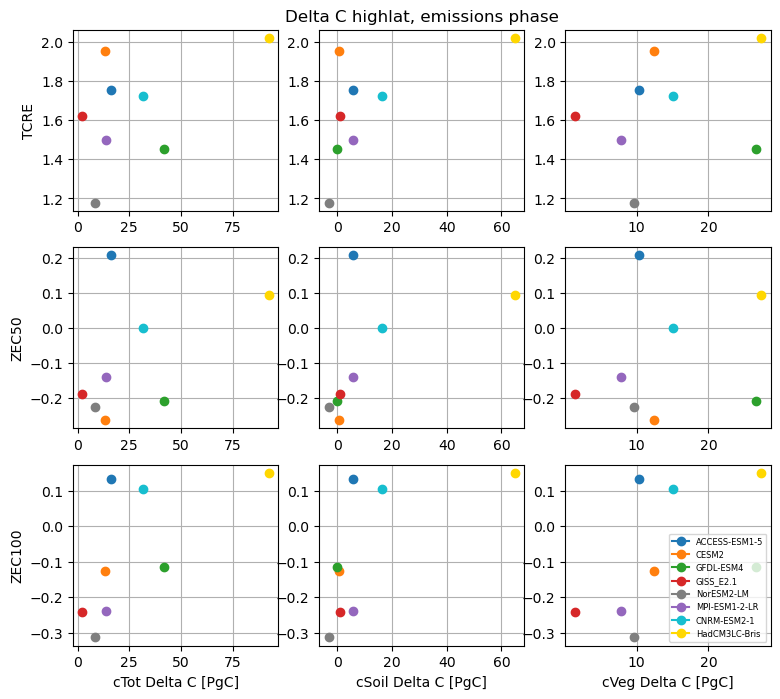

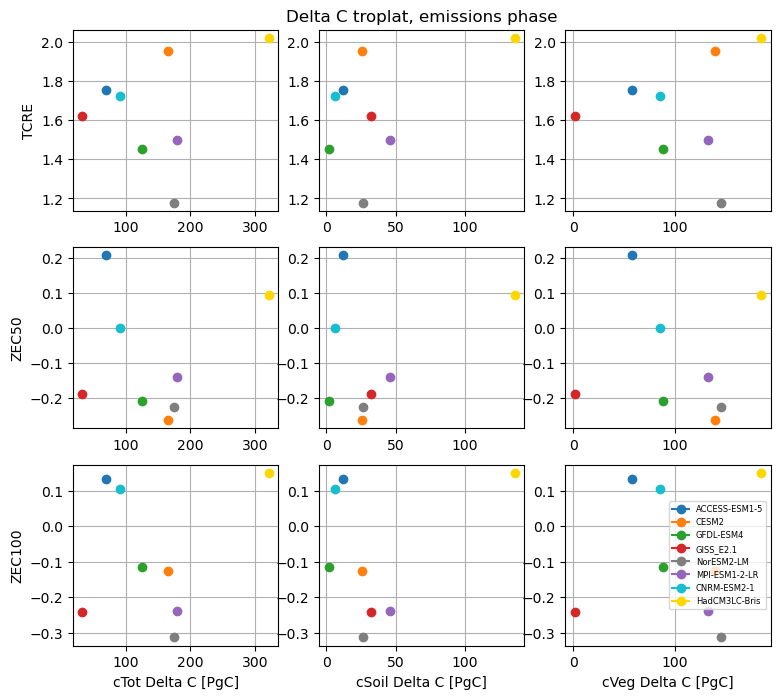

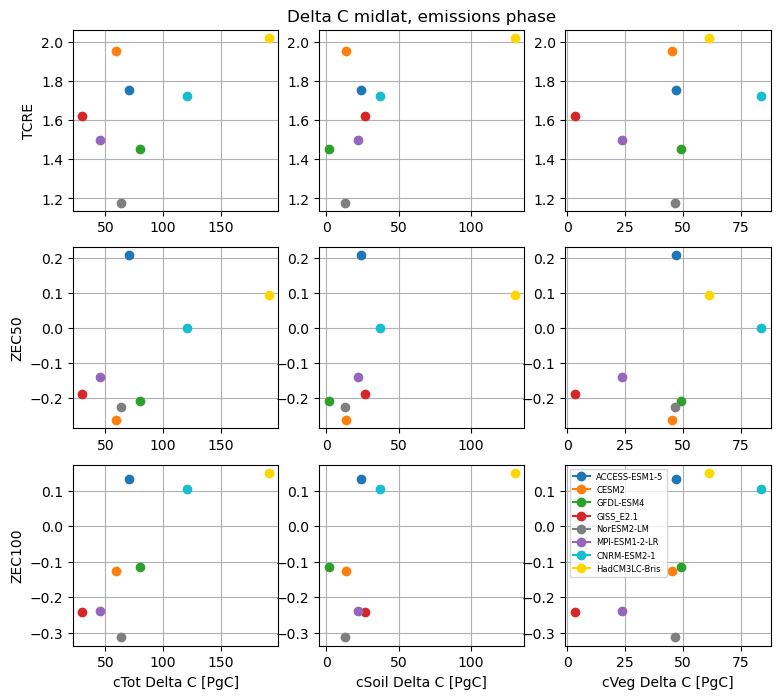

In [33]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('Delta C ' +latlist[l] +', emissions phase')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

    # add grid lines after all models are plotted
    for i in range(3):
        for j in range(3):
            axes[i,j].grid()
        
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.png", bbox_inches='tight')


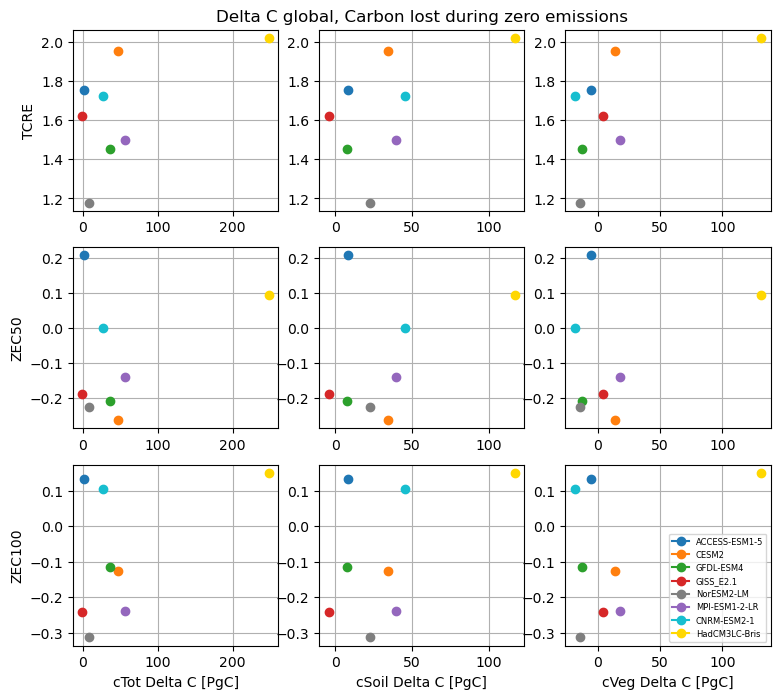

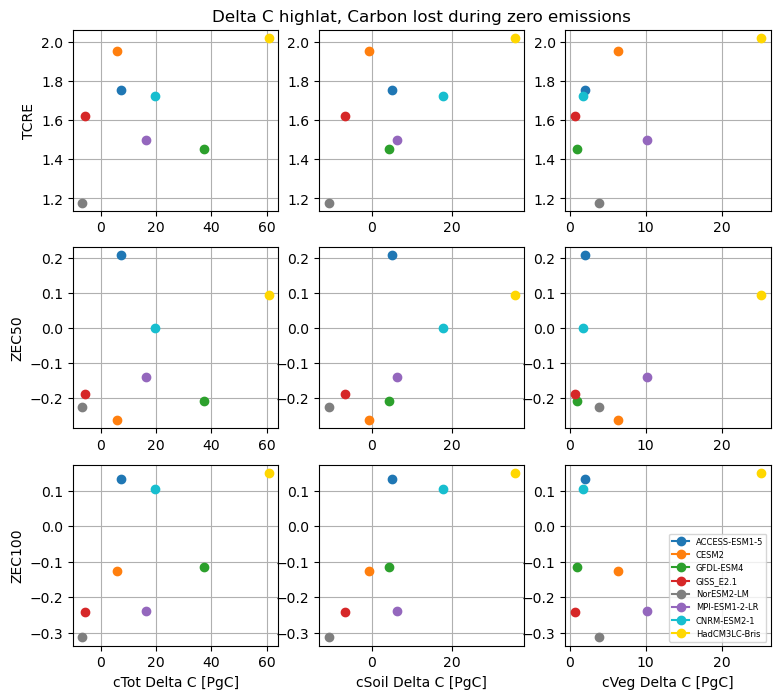

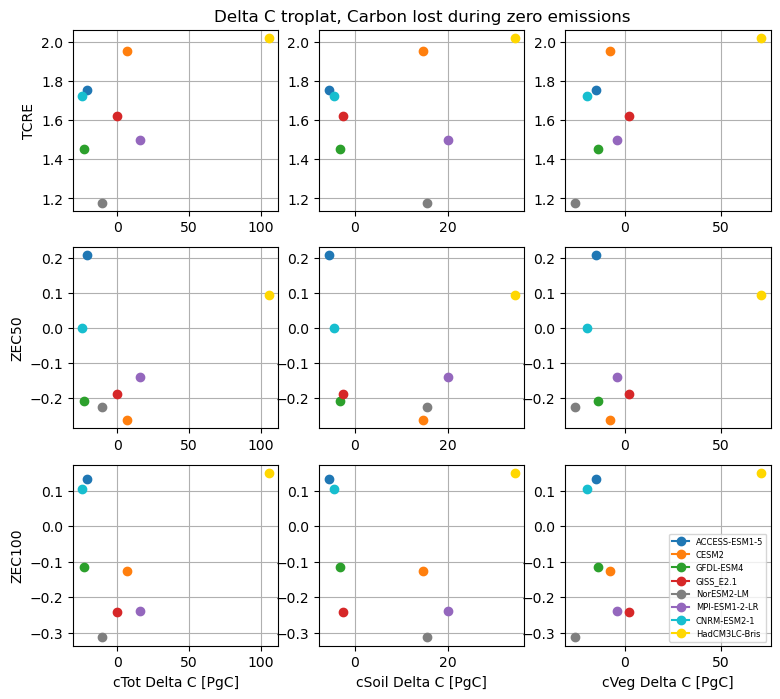

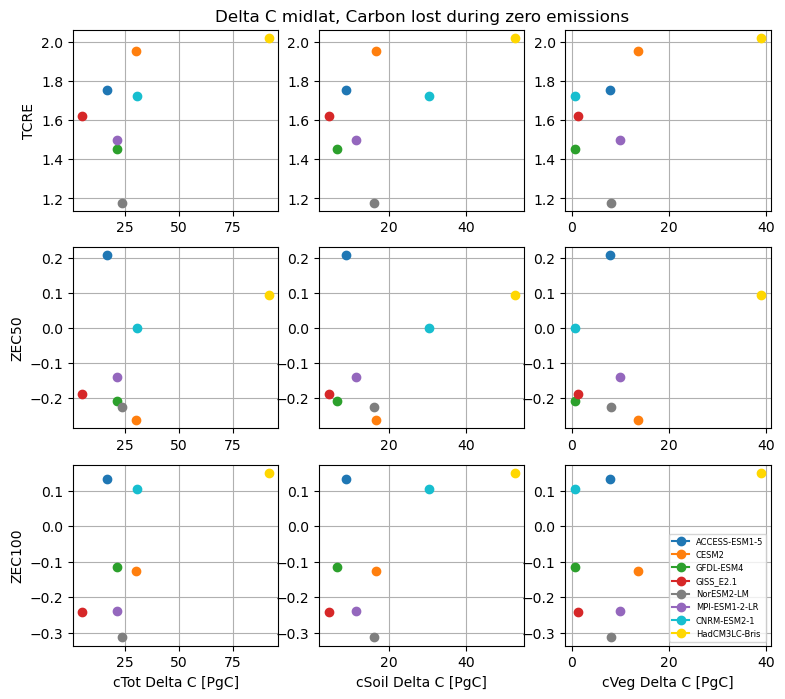

In [34]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=1

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('Delta C ' +latlist[l] +', Carbon lost during zero emissions')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

    # add grid lines after all models are plotted
    for i in range(3):
        for j in range(3):
            axes[i,j].grid()
            
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.png", bbox_inches='tight')


# Testing

# #---------# Snippets below #-----------#

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'][il].values
    zec50=esm_metrics_flat10['zec50'][il].values
    zec100=esm_metrics_flat10['zec100'][il].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        deltaC=nzC-initC
        axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[0,vi].grid()
    
        axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[1,vi].grid()
    
        axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[2,vi].grid() 
    



axes[0,1].set_title('Delta C ' +latlist[l] +', emissions phase')
#axes[0,1].set_title(varlist[vlist[1]])
#axes[0,2].set_title(varlist[vlist[2]])



axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'].values
    zec50=esm_metrics_flat10['zec50'].values
    zec100=esm_metrics_flat10['zec100'].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        initC=np.mean(C_global_mat[0:9,m,0,0])
        nzC=np.mean(C_global_mat[90:109,m,0,0])
        deltaC=nzC-initC
        axes[vi,0].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[vi,0].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,1])
        nzC=np.mean(C_global_mat[90:109,m,0,1])
        deltaC=nzC-initC
        axes[vi,1].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[vi,1].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,2])
        nzC=np.mean(C_global_mat[90:109,m,0,2])
        deltaC=nzC-initC
        axes[vi,2].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[vi,2].grid() 
    



axes[0,0].set_title('cTot')
axes[0,1].set_title('cVeg')
axes[0,2].set_title('cSoil')



axes[2,0].set_xlabel('cTot Delta C [PgC]')
axes[2,1].set_xlabel('cVeg Delta C [PgC]')
axes[2,2].set_xlabel('cSoil Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter.pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter.jpg", bbox_inches='tight')


In [ ]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

#e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
      #  l=0
        for l in range(len(latlist)):
          #  initC=np.mean(C_global_mat[0:9,m,0,v])
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
          #  nzC=np.mean(C_global_mat[190:199,m,2,v])
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    
#        initC=np.mean(C_troplat_mat[0:9,m,0,v])
#        nzC=np.mean(C_troplat_mat[190:199,m,2,v])
#        axes[vi,1].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,1].grid()
#    
#        initC=np.mean(C_midlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_midlat_mat[190:199,m,2,v])
#        axes[vi,2].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,2].grid() 
#    
#        initC=np.mean(C_highlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_highlat_mat[190:199,m,2,v])
#        axes[vi,3].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,3].grid()


#axes[0,0].set_title('Global')
#axes[0,1].set_title('Tropical')
#axes[0,2].set_title('Mid Latitdes')
#axes[0,3].set_title('High Latitudes')

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


In [ ]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
#C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])


#for m in range(len(modellist)):
#for m in range(0):#len(['CESM2'])):#'GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
m=4
model=modellist[m]
print('loading model: ' +model)

#----loop over experiments----# 
#for e in range(0):#len(runlist)):
e=0
run = runlist_wc[e]
print('loading run: ' +run)


ds=data_dict[modellist[m] +'_' +runlist[e]]
ds_area = data_dict[modellist[m] +'_' +'areacella']
ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
#area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
#landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)

#area = ds_area['areacella']#.reindex_like(ds, method='nearest',tolerance=0.05)
area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
#area = area[:,-1]
landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)


if landfrac.max(dim=['lat','lon'])>1:
    landfrac=landfrac/100
    
landarea=area*landfrac

troplat=30
highlat=60



#----loop over variables----#
#for v in range(len(varlist)):
v=2
var=varlist[v]
#print('loading variable: ' +var)

data_var= weighted_temporal_mean(ds, var)

# total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
# our area variable is in m2
C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
   # C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
   # C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
   # C_global_mat[0:len(C_global),m,e,v]= C_global
   # C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
   # C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
   # C_midlat_mat[0:len(C_global),m,e,v]= C_midlat




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

In [ ]:
landfrac.plot()

In [ ]:
model='GISS_E2.1'

ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

area_vec = ds_area['areacella'][:,-1]
area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])

landarea=ds_area['areacella']*ds_landfrac['sftlf']

#landarea.plot()

ds_landfrac['sftlf'].plot()
#ds_area['areacella'].plot()

In [ ]:
a=landarea.sum(dim=['lon']).values

c=ds[var].mean(dim=['time','lon']).values

zm=a*c

g=np.nansum(zm)/np.nansum(a)

print(g)

In [ ]:
plt.plot(C_global)

#(((data_var)).sum(dim=['lat','lon'])).plot()

In [ ]:
landfrac.plot()

In [ ]:
#area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
#landfrac=ds_landfrac['sftlf']#.reindex_like(ds, method='nearest',tolerance=0.05)
#areaV=area[:,-1]
#landarea=areaV*landfrac

#data_var.mean(dim='time').plot()
(data_var).plot()

In [ ]:
area[:,-1]

In [ ]:
# [0:len(C_global),m,e,v]
fig = plt.figure(figsize=(8,5))

# [0:len(C_global),m,e,v]
e=0
v=2
m=4

#for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
 

model=modellist[m]

fig = plt.figure(figsize=(8,5))
plt.plot(C_highlat_mat[0:100,m,e,v],label='highlat')
plt.plot(C_midlat_mat[0:100,m,e,v],label='midlat')
plt.plot(C_troplat_mat[0:100,m,e,v],label='troplat')
plt.plot(C_global_mat[0:100,m,e,v],label='global')

plt.title(varlist[v] +' ' +modellist[m] +' ' +runlist[e])
#plt.ylabel(
plt.legend()
plt.grid()


In [ ]:
landarea.plot()


In [ ]:
dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')